In [ ]:
# handle image
import cv2
from matplotlib import pyplot as plt

# utils
import os
import random
import imutils
import numpy as np
import pandas as pd

# machine learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

import tensorflow.keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configurações

In [ ]:
CURRENT_MODEL_VERSION = 2

TYPE_LOSS = "binarycross"

MODEL_LABEL = "simple" 

IMG_SHAPE = (150, 150, 3)
EMBEDDING_DIM = 1024

RESIZED_IMG_SHAPE = (IMG_SHAPE[0], IMG_SHAPE[1])

COLAB_PATH = "drive/MyDrive/"

DATASET_PATH = COLAB_PATH +'datasets/cropped_eyes.csv'

TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.1

BATCH_SIZE = 64
EPOCHS = 120

BASE_OUTPUT = COLAB_PATH + "output"
MODEL_EXTENSION = ".hdf5"

FOLDER = os.path.sep.join([BASE_OUTPUT , MODEL_LABEL])
FOLDER = os.path.sep.join([FOLDER , TYPE_LOSS])
FOLDER = os.path.sep.join([FOLDER,"v{}".format(CURRENT_MODEL_VERSION)])

ACC_PATH = os.path.sep.join([FOLDER,"acc_test.txt"])
MODEL_INFO_PATH = os.path.sep.join([FOLDER,"model_info.txt"])

MODEL_PATH = os.path.sep.join([FOLDER, "siamese_model_{}".format(CURRENT_MODEL_VERSION)])
PLOT_PATH = os.path.sep.join([FOLDER, "plot-{}.png".format(CURRENT_MODEL_VERSION)])
PLOT_FEATURE_ARCHTECTURE_PATH = os.path.sep.join([FOLDER, "feature_extractor_arch-{}.png".format(CURRENT_MODEL_VERSION)])
PLOT_MODEL_ARCHTECTURE_PATH = os.path.sep.join([FOLDER, "model_arch-{}.png".format(CURRENT_MODEL_VERSION)])

SCORES = ['accuracy']

In [ ]:
if not os.path.isdir(FOLDER):
  os.mkdir(FOLDER)

### Funções preprocessamento

In [ ]:
def preprocess_image(filename):
  image = cv2.imread(filename)
  image = cv2.resize(image, RESIZED_IMG_SHAPE, interpolation = cv2.INTER_AREA)
  if IMG_SHAPE[2] == 1:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  return image

In [ ]:
def preprocess_triplets(images, labels):
  unique_labels = np.unique(labels)
  num_classes = len(unique_labels)
  
  idx = { "{}".format(i) :np.where(labels == i)[0] for i in unique_labels }

  pair_images = []
  pair_labels = []

  for idxA in range(len(images)):

    currentImage = preprocess_image(images[idxA])
    label = labels[idxA]

    idxB = np.random.choice(idx[label])
    posImage = preprocess_image(images[idxB])

    pair_images.append([currentImage, posImage])
    pair_labels.append([1])

    negIdx = np.where(labels != label)[0]
    negImage = preprocess_image(images[np.random.choice(negIdx)])

    pair_images.append([currentImage, negImage])
    pair_labels.append([0])
  
  return (np.array(pair_images), np.array(pair_labels))

### Funções NN

In [ ]:
def build_siamese_model(inputShape, embeddingDim=EMBEDDING_DIM):
  inputs = Input(inputShape)
  
  x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)
  
  x = Conv2D(filters=64, kernel_size=(2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.3)(x)

  
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  
  model = Model(inputs, outputs)
  
  return model

In [ ]:
def build_network():
  imgA = Input(shape=IMG_SHAPE)
  imgB = Input(shape=IMG_SHAPE)
  featureExtractor = build_siamese_model(IMG_SHAPE)
  featsA = featureExtractor(imgA)
  featsB = featureExtractor(imgB)

  distance = Lambda(euclidean_distance)([featsA, featsB])
  outputs = Dense(1, activation="sigmoid")(distance)

  model = Model(inputs=[imgA, imgB], outputs=outputs)
  return model

In [ ]:
def euclidean_distance(vectors):
  (featsA, featsB) = vectors

  sumSquared = K.sum(K.square(featsA - featsB), axis=1,
    keepdims=True)
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Treinamento Loss e Accuracy")
	plt.xlabel("Épocas")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

### Criação do modelo

In [ ]:
dataset = pd.read_csv(DATASET_PATH, index_col="Unnamed: 0")

In [ ]:
#dataset = dataset[:][:100]

In [ ]:
(pair_images, pair_labels) = preprocess_triplets(dataset['image_path'],dataset['class'])

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(pair_images, pair_labels, test_size=TEST_SIZE + VALIDATION_SIZE)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=TEST_SIZE)

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(2720, 2, 150, 150, 3)
(2720, 1)
(932, 2, 150, 150, 3)
(932, 1)
(234, 2, 150, 150, 3)
(234, 1)


(None, None)

In [ ]:
del(pair_images)
del(pair_labels)

In [ ]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


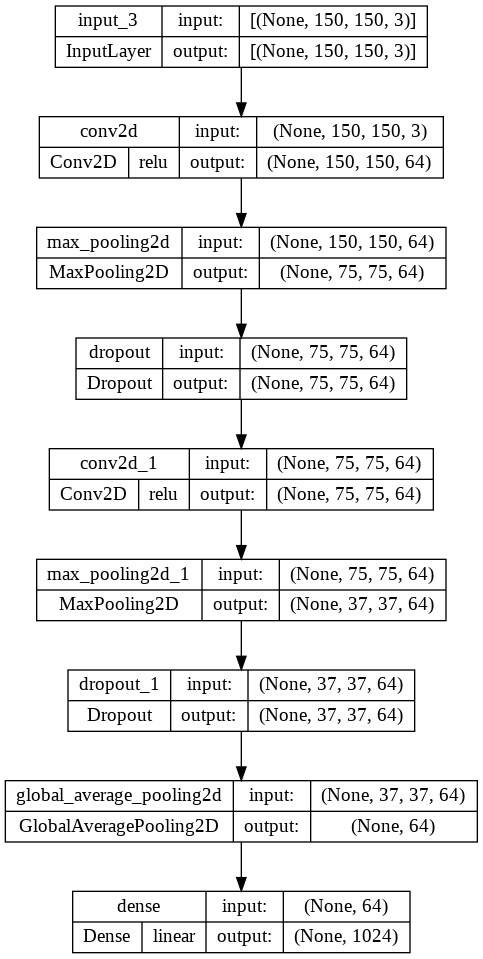

In [ ]:
plot_model(featureExtractor,to_file=PLOT_FEATURE_ARCHTECTURE_PATH,show_shapes=True,show_layer_activations=True)

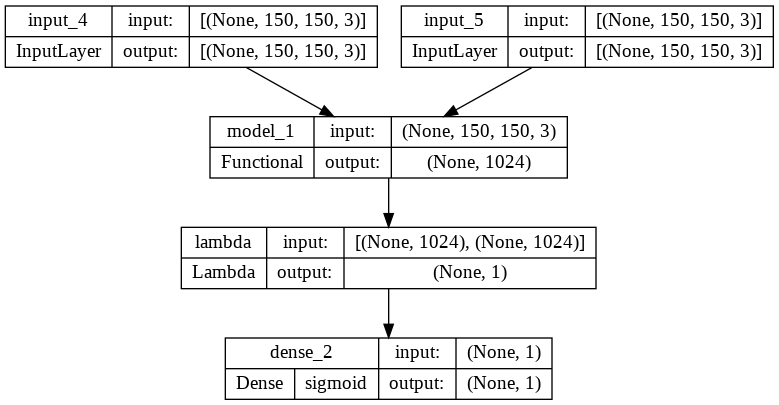

In [ ]:
model = build_network()
plot_model(model,to_file=PLOT_MODEL_ARCHTECTURE_PATH,show_shapes=True,show_layer_activations=True)

In [ ]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=SCORES)

[INFO] compiling model...


In [26]:
history = model.fit(
                    [X_train[:, 0], X_train[:, 1]], y_train[:],
                    validation_data=([X_valid[:, 0], X_valid[:, 1]], y_valid[:]),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    )

Epoch 1/120
43/43 [==============================] - 230s 5s/step - loss: 0.5502 - accuracy: 0.7732 - val_loss: 0.5353 - val_accuracy: 0.7704
Epoch 2/120
43/43 [==============================] - 238s 6s/step - loss: 0.5444 - accuracy: 0.7688 - val_loss: 0.5429 - val_accuracy: 0.7865
Epoch 3/120
43/43 [==============================] - 236s 5s/step - loss: 0.5456 - accuracy: 0.7728 - val_loss: 0.5259 - val_accuracy: 0.7811
Epoch 4/120
43/43 [==============================] - 235s 5s/step - loss: 0.5414 - accuracy: 0.7732 - val_loss: 0.5331 - val_accuracy: 0.7511
Epoch 5/120
43/43 [==============================] - 236s 5s/step - loss: 0.5406 - accuracy: 0.7768 - val_loss: 0.5224 - val_accuracy: 0.7811
Epoch 6/120
43/43 [==============================] - 235s 5s/step - loss: 0.5332 - accuracy: 0.7728 - val_loss: 0.5267 - val_accuracy: 0.7758
Epoch 7/120
43/43 [==============================] - 243s 6s/step - loss: 0.5337 - accuracy: 0.7768 - val_loss: 0.5149 - val_accuracy: 0.7758
Epoch 

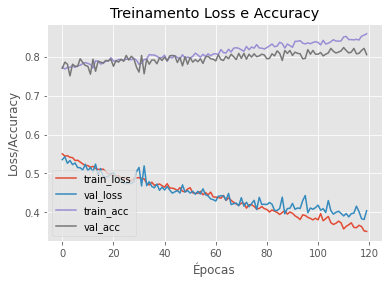

In [27]:
plot_training(history,PLOT_PATH)

### Salvar modelo

In [28]:
model.save(MODEL_PATH)

### Recuperar modelo salvo

In [29]:
model_recovered = load_model(MODEL_PATH)

### Aplicar modelo aos dados de teste

In [30]:
y_pred = model_recovered.predict([X_test[:, 0], X_test[:, 1]])

8/8 [==============================] - 4s 516ms/step


In [31]:
mapper_class = lambda value: 1 if value > 0.5 else 0

In [32]:
y_mapped = [ mapper_class(value) for value in  y_pred]
y_mapped = np.asarray(y_mapped).reshape(-1,1)

In [33]:
evaluation = abs(y_mapped - y_test)

In [34]:
acc = (evaluation.shape[0] - sum(evaluation))/evaluation.shape[0]

In [35]:
acc

array([0.81196581])

In [36]:
with open(ACC_PATH, 'w') as f:
    f.write("acc: {}\n".format(acc))
    f.write("batch size: {}\n".format(BATCH_SIZE))
    f.write("epochs: {}\n".format(EPOCHS))

In [37]:
with open(MODEL_INFO_PATH, 'w') as f:
    model_recovered.summary(print_fn=lambda x: f.write(x + '\n'))
    